# Water retention curve

## van Genuchten 

**Capillary pressure - saturation function**

Calculate first $\theta_e$:

$$ \theta_e = \left( 1 + \left( \alpha h \right)^n \right)^{-m} $$

With $m = 1 - 1/n$. Then, calculate the saturation:

$$ \theta = \theta_e \left( \theta_s - \theta_r \right) + \theta_r $$

Capillarity is defined as:

$$ 
\begin{array}{rl}
\dfrac{d\theta}{dh} =& \left( \theta_s - \theta_r \right)  \dfrac{d\theta_e}{dh} \\
\\
 =& - \left( \theta_s - \theta_r \right) \left( \alpha m n \left( \alpha h \right)^{n-1} \left( 1 + \left( \alpha h \right)^n \right)^{-m-1} \right)
\end{array}
$$

## Mualem

**Relative permeability function**

With $\theta_e$, calculate:

$$ k_r = \sqrt{\theta_e} \left( 1 - \left( 1 - \left( \theta_e \right)^{1/m} \right) \right)^2 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import UnivariateSpline

In [16]:
## Globals
α = 2.79 #1/m
θs = 0.385
θr = 0.012
n = 7.26
m = 1 - 1/n
Ks = 2.07E-4  #m/s
qtarget = 3.32E-6 #m/s
Kfc = 1.16E-9 #m/s
krfc = Kfc/Ks

def vanGenuchten(h:np.array) -> np.array:
    θe = np.where(
        h >= 0,
        1.0,
        np.power(1 + np.power(α*h*np.sign(h), n), -m)
    )
    return θe

def waterSaturation(h:np.array) -> np.array:
    θe = vanGenuchten(h)
    θ = θe * (θs - θr) + θr
    return θ

def mualemPermeability(h:np.array) -> np.array:
    θe = vanGenuchten(h)
    kr = np.sqrt(θe) * np.power(1-np.power(1-np.power(θe, 1/m), m), 2)
    return kr

def capillarity(h) -> np.array:
    x = np.where(
        h >= 0,
        0.0,
        α*m*n * np.power(α*h*np.sign(h), n-1) * np.power(1 + np.power(α*h*np.sign(h), n), -m-1)
        )
    x *= (θs - θr)
    return x

h = np.concatenate([np.geomspace(-2, -1.0E-3, 500), np.linspace(0,2,10)])
θe = vanGenuchten(h)
θ = waterSaturation(h)
kr = mualemPermeability(h)
Ch = capillarity(h)

In [17]:
h_krfc = h[np.argmin(np.abs(kr-krfc))]
θfc = waterSaturation(h_krfc)

qin = Ks * kr
h_qtarget = h[np.argmin(np.abs(qin - qtarget))]

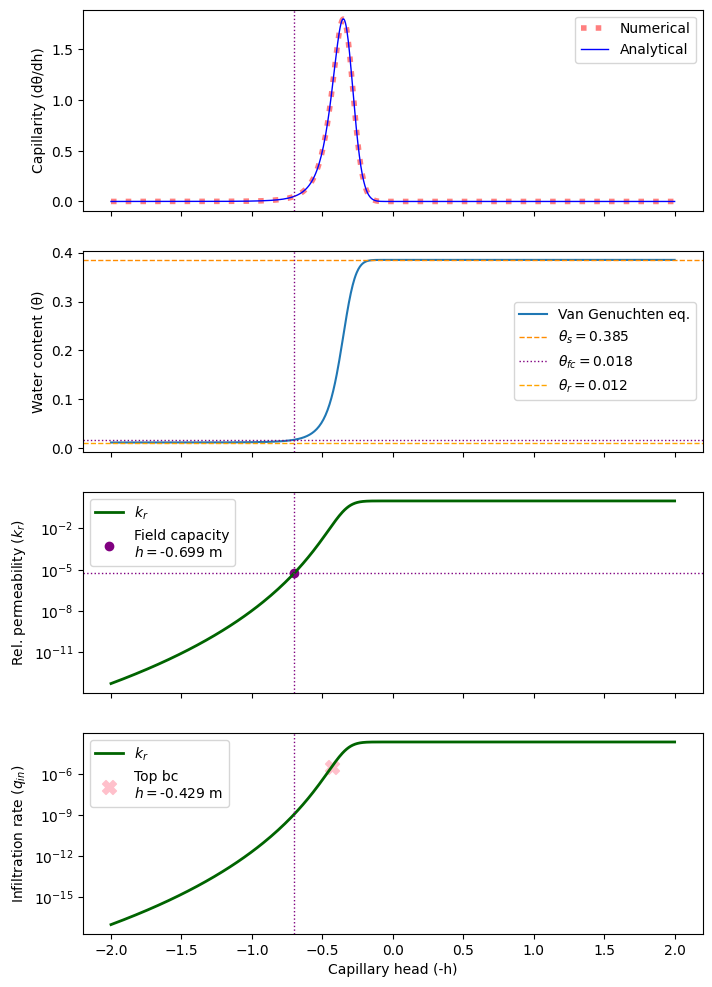

In [24]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[8,12])
ax = axs[0]
ax.plot(h, np.gradient(θ,h), lw=4, ls='dotted', c='red', alpha=0.5, label="Numerical")
ax.plot(h, Ch, lw=1, c='blue', label="Analytical")
ax.set_ylabel("Capillarity (dθ/dh)")
ax.legend()

ax = axs[1]
ax.plot(h,θ, label="Van Genuchten eq.")
ax.axhline(y=θs, ls='dashed', lw=1, c='darkorange', label=fr"$\theta_s={θs}$")
ax.axhline(y=θfc, label=rf"$\theta_{{fc}}=${θfc:.3f}", ls=":", lw=1, c="purple")
ax.axhline(y=θr, ls='dashed', lw=1, c='orange', label=fr"$\theta_r={θr}$")
ax.set_ylabel("Water content (θ)")
ax.legend()

ax = axs[2]
ax.plot(h, kr, lw=2, c='darkgreen', label="$k_r$")
ax.scatter([h_krfc],[krfc], label=f"Field capacity\n$h=${h_krfc:.3f} m", c="purple")
ax.axhline(y=krfc, ls=":", lw=1, c="purple")
ax.set_yscale('log')
ax.set_ylabel("Rel. permeability ($k_r$)")
ax.legend()

ax = axs[3]
ax.plot(h, qin, lw=2, c='darkgreen', label="$k_r$")
ax.scatter([h_qtarget],[qtarget], label=f"Top bc\n$h=${h_qtarget:.3f} m", c="pink", marker="X", s=100)
# ax.axhline(y=krfc, ls=":", lw=1, c="purple")
ax.set_yscale('log')
ax.set_ylabel("Infiltration rate ($q_{in}$)")
ax.set_xlabel("Capillary head (-h)")
ax.legend()


for ax in axs:
    ax.axvline(x=h_krfc, ls=":", lw=1, c="purple")

plt.show()

In [25]:
waterSaturation(h_qtarget)

0.10996623776206825

## Solve for $h$ to find an infiltration rate $q_i$

$$ q_i(h) = - Ks k_r(h) \left( \cancel{\nabla h} + 1 \right) $$